<a href="https://colab.research.google.com/github/vjihye/TIL/blob/master/3_11__A_Recurrent_Layer_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!unzip -qq '/content/gdrive/MyDrive/aclImdb.zip'

In [14]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [68]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname)) 
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
          labels.append(0)
      else:
          labels.append(1)

### Tokenizing the Data

In [69]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
import numpy as np

In [70]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)

Found 88582 unique tokens.


In [71]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [72]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [73]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [74]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_5 (Flatten)         (None, 10000)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                320032    
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [76]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 242ms/step - loss: 1.3463 - acc: 0.5800 - val_loss: 0.6926 - val_acc: 0.5258
Epoch 2/10
7/7 [==============================] - 1s 219ms/step - loss: 0.6840 - acc: 0.6250 - val_loss: 0.8027 - val_acc: 0.5058
Epoch 3/10
7/7 [==============================] - 1s 219ms/step - loss: 0.4963 - acc: 0.7650 - val_loss: 0.8145 - val_acc: 0.5025
Epoch 4/10
7/7 [==============================] - 1s 218ms/step - loss: 0.3548 - acc: 0.8900 - val_loss: 0.9799 - val_acc: 0.5091
Epoch 5/10
7/7 [==============================] - 1s 121ms/step - loss: 0.3890 - acc: 0.7950 - val_loss: 0.9536 - val_acc: 0.5052
Epoch 6/10
7/7 [==============================] - 1s 122ms/step - loss: 0.1584 - acc: 0.9750 - val_loss: 0.7897 - val_acc: 0.5472
Epoch 7/10
7/7 [==============================] - 1s 123ms/step - loss: 0.2985 - acc: 0.8250 - val_loss: 0.7300 - val_acc: 0.5606
Epoch 8/10
7/7 [==============================] - 1s 122ms/step - loss: 0.0745 - acc: 0.99

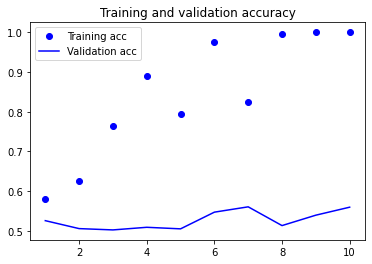

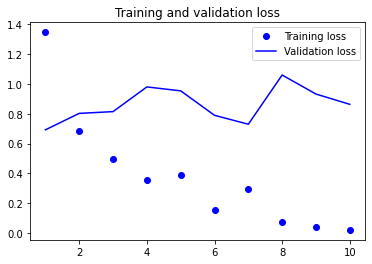

In [77]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Numpy implementation of a simple RNN

In [1]:
import numpy as np

In [2]:
timesteps = 100
input_features = 32
output_features = 64

In [3]:
inputs = np.random.random((timesteps, input_features))

In [5]:
state_t = np.zeros((output_features,))

In [6]:
w = np.random.random((output_features, input_features))
u = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

In [9]:
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(w, input_t) + np.dot(u, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t

In [10]:
final_output_sequence = np.concatenate(successive_outputs, axis = 0)

In [11]:
from keras.layers import SimpleRNN

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000,32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [15]:
model = Sequential()

model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [16]:
model = Sequential()

model.add(Embedding(10000,32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## IMDB 영화 리뷰 분류 문제에 적용
### - Preparing the IMDB data

In [18]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [19]:
max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)


Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### - Training the model with Embedding and SimpleRNN layers

In [25]:
from keras.layers import Dense

In [26]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Dense(1, activation = 'sigmoid'))

In [27]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [28]:
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10


ValueError: ignored